<a href="https://colab.research.google.com/github/JackSagliano/water-level-prediction/blob/main/Water_level_prediction_modello2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌊 Water Level Prediction - Versione MEMORY-EFFICIENT
## Ottimizzata per RAM limitata

Questa versione usa:
- **Sampling dei nodi** (non tutti i 5000 ad ogni timestep)
- **Dataset on-the-fly** (genera sequenze durante il training)
- **Gradienti accumulati** per batch effettivi più grandi

**Target:** Battere baseline RMSE = 0.0859

## 1. Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Libera memoria
import gc
gc.collect()
torch.cuda.empty_cache() if torch.cuda.is_available() else None

print("✓ Setup completato!")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

✓ Setup completato!
PyTorch: 2.9.0+cu126
CUDA: True


## 2. Caricamento Dati

In [2]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/ProgettoDeepLearning/'
print("Caricamento dati...\n")

# Carica dati
era5_train = np.load(BASE_PATH + 'ERA5_adriatic_u10v10sp_2010-2019.npy')
era5_test = np.load(BASE_PATH + 'ERA5_adriatic_u10v10sp_2020.npy')
eph_train = np.load(BASE_PATH + 'dist_alt_az_moon-sun_coord13-45_2010-2019_norm.npy')
eph_test = np.load(BASE_PATH + 'dist_alt_az_moon-sun_coord13-45_2020_norm.npy')
wl_train = np.load(BASE_PATH + 'wl_2010-2020.npy')
wl_test = np.load(BASE_PATH + 'wl_2020.npy')
lat_vec = np.load(BASE_PATH + 'lat.npy')
lon_vec = np.load(BASE_PATH + 'lon.npy')

print(f"ERA5 train: {era5_train.shape}")
print(f"Effemeridi train: {eph_train.shape}")
print(f"Water level train: {wl_train.shape}")
print(f"\n✓ Dati caricati!")

# Separa variabili ERA5
train_u10 = era5_train[0]
train_v10 = era5_train[1]
train_msl = era5_train[2]

test_u10 = era5_test[0]
test_v10 = era5_test[1]
test_msl = era5_test[2]

# Transponi effemeridi
eph_train = eph_train.T  # (87648, 6)
eph_test = eph_test.T

print(f"\nVariabili separate:")
print(f"  u10: {train_u10.shape}")
print(f"  v10: {train_v10.shape}")
print(f"  msl: {train_msl.shape}")
print(f"  eph: {eph_train.shape}")

Mounted at /content/drive
Caricamento dati...

ERA5 train: (3, 87648, 5, 9)
Effemeridi train: (6, 87648)
Water level train: (87648, 5000)

✓ Dati caricati!

Variabili separate:
  u10: (87648, 5, 9)
  v10: (87648, 5, 9)
  msl: (87648, 5, 9)
  eph: (87648, 6)


## 3. Preprocessing

In [3]:
print("Normalizzazione ERA5...")

u10_scaler = StandardScaler()
v10_scaler = StandardScaler()
msl_scaler = StandardScaler()

train_u10_norm = u10_scaler.fit_transform(
    train_u10.reshape(train_u10.shape[0], -1)
).reshape(train_u10.shape)

train_v10_norm = v10_scaler.fit_transform(
    train_v10.reshape(train_v10.shape[0], -1)
).reshape(train_v10.shape)

train_msl_norm = msl_scaler.fit_transform(
    train_msl.reshape(train_msl.shape[0], -1)
).reshape(train_msl.shape)

test_u10_norm = u10_scaler.transform(
    test_u10.reshape(test_u10.shape[0], -1)
).reshape(test_u10.shape)

test_v10_norm = v10_scaler.transform(
    test_v10.reshape(test_v10.shape[0], -1)
).reshape(test_v10.shape)

test_msl_norm = msl_scaler.transform(
    test_msl.reshape(test_msl.shape[0], -1)
).reshape(test_msl.shape)

print("✓ ERA5 normalizzato!")

# Normalizza coordinate
lat_mean, lat_std = lat_vec.mean(), lat_vec.std()
lon_mean, lon_std = lon_vec.mean(), lon_vec.std()

lat_norm = (lat_vec - lat_mean) / lat_std
lon_norm = (lon_vec - lon_mean) / lon_std

print(f"✓ Coordinate normalizzate!")

# Libera memoria
del era5_train, era5_test, train_u10, train_v10, train_msl, test_u10, test_v10, test_msl
gc.collect()

Normalizzazione ERA5...
✓ ERA5 normalizzato!
✓ Coordinate normalizzate!


0

## 4. Dataset Memory-Efficient

**Strategia:**
- Non creare tutte le sequenze in memoria
- Genera sequenze on-the-fly durante il training
- Campiona solo un subset di nodi ad ogni epoca

In [4]:
# --- CONFIGURAZIONE PRO ---
SEQ_LEN = 48  # 48 ore di memoria (cattura 2 cicli di marea completi)
NODES_PER_T = 100 # Aumentato per vedere più costa
BATCH_SIZE = 256

class MemoryEfficientDataset(Dataset):
    def __init__(self, eph, u10, v10, msl, wl, lat, lon, seq_len=48,
                 nodes_per_timestep=100):
        self.eph = eph
        self.u10 = u10
        self.v10 = v10
        self.msl = msl
        self.wl = wl
        self.lat = lat
        self.lon = lon
        self.seq_len = seq_len
        self.nodes_per_t = nodes_per_timestep
        self.timesteps = wl.shape[0]
        self.num_nodes = wl.shape[1]

        self.samples = []
        # Step ridotto per generare meno campioni ma più significativi
        # Generiamo un campione ogni 2 ore per non saturare la RAM con SEQ_LEN 48
        for t in range(seq_len, self.timesteps, 2):
            sampled_nodes = np.random.choice(self.num_nodes,
                                            size=self.nodes_per_t,
                                            replace=False)
            for n in sampled_nodes:
                self.samples.append((t, n))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        t, n = self.samples[idx]

        eph_seq = self.eph[t-self.seq_len:t]

        # ERA5: (Seq, H, W) per ogni variabile
        u10_seq = self.u10[t-self.seq_len:t] # (48, 5, 9)
        v10_seq = self.v10[t-self.seq_len:t]
        msl_seq = self.msl[t-self.seq_len:t]

        # Stack per ottenere canali: (Seq, 3, 5, 9)
        # Nota: PyTorch vuole i canali prima delle dimensioni spaziali
        era5_seq = np.stack([u10_seq, v10_seq, msl_seq], axis=1)

        return {
            'eph': torch.FloatTensor(eph_seq),
            'era5': torch.FloatTensor(era5_seq), # Shape: (48, 3, 5, 9)
            'coords': torch.FloatTensor([self.lat[n], self.lon[n]]),
            'target': torch.FloatTensor([self.wl[t, n]])
        }
train_end = 8760 * 9   # 9 anni di dati orari per il training
val_start = train_end  # Il resto è per la validazione
# Rigenerazione Dataloader
print("Creazione Dataset PRO (48h)...")
train_dataset = MemoryEfficientDataset(
    eph_train[:train_end], train_u10_norm[:train_end], train_v10_norm[:train_end], train_msl_norm[:train_end],
    wl_train[:train_end], lat_norm, lon_norm, seq_len=SEQ_LEN, nodes_per_timestep=NODES_PER_T
)
val_dataset = MemoryEfficientDataset(
    eph_train[val_start:], train_u10_norm[val_start:], train_v10_norm[val_start:], train_msl_norm[val_start:],
    wl_train[val_start:], lat_norm, lon_norm, seq_len=SEQ_LEN, nodes_per_timestep=NODES_PER_T * 2 # Più nodi in validazione
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print(f"Dataset pronto: {len(train_dataset)} training samples.")

Creazione Dataset PRO (48h)...
Dataset pronto: 3939600 training samples.


## 5. Modello

In [5]:
class CNN_LSTM_Predictor(nn.Module):
    def __init__(self, seq_len=48, hidden_size=128, dropout=0.3):
        super().__init__()

        # 1. Encoder Spaziale (CNN per le mappe meteo)
        # Input: (Batch*Seq, 3, 5, 9)
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), # Esce (16, 5, 9)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=(3,3), padding=0), # Esce (32, 3, 7)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 3 * 7, 64), # Proietta a 64 features
            nn.ReLU()
        )

        # 2. Encoder Effemeridi
        self.eph_encoder = nn.Sequential(
            nn.Linear(6, 32),
            nn.ReLU()
        )

        # 3. LSTM Temporale
        # Input size: 64 (da CNN) + 32 (da Eph) = 96
        self.lstm = nn.LSTM(
            input_size=96,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=dropout
        )

        # 4. Encoder Coordinate
        self.coord_encoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU()
        )

        # 5. Predittore Finale
        self.predictor = nn.Sequential(
            nn.Linear(hidden_size + 32, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, eph_seq, era5_seq, coords):
        # era5_seq shape: (Batch, Seq, 3, 5, 9)
        B, T, C, H, W = era5_seq.shape

        # Fondere Batch e Time per passare nella CNN
        # (B*T, 3, 5, 9)
        cnn_in = era5_seq.view(B * T, C, H, W)
        cnn_out = self.cnn(cnn_in) # (B*T, 64)

        # Ripristinare la dimensione temporale
        # (B, T, 64)
        cnn_features = cnn_out.view(B, T, -1)

        # Processare effemeridi
        eph_features = self.eph_encoder(eph_seq) # (B, T, 32)

        # Concatenare feature CNN e Effemeridi
        lstm_input = torch.cat([cnn_features, eph_features], dim=-1) # (B, T, 96)

        # LSTM
        lstm_out, _ = self.lstm(lstm_input)
        last_hidden = lstm_out[:, -1, :] # Prendiamo l'ultimo stato (B, Hidden)

        # Aggiungere coordinate spaziali del nodo
        coord_feat = self.coord_encoder(coords) # (B, 32)

        # Combinare tutto
        combined = torch.cat([last_hidden, coord_feat], dim=-1)

        return self.predictor(combined).squeeze(-1)

# Reinizializza il modello
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_LSTM_Predictor(seq_len=SEQ_LEN).to(device)
print("Modello CNN-LSTM inizializzato.")

Modello CNN-LSTM inizializzato.


## 6. Training con Gradient Accumulation

In [ ]:
EPOCHS = 50
LEARNING_RATE = 0.001
PATIENCE = 7
ACCUM_STEPS = 2  # Accumula gradienti per simulare batch più grandi

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                  factor=0.5, patience=3,
                                                  min_lr=1e-6)
criterion = nn.MSELoss()

print(f"Configurazione:")
print(f"  Epoche: {EPOCHS}")
print(f"  LR: {LEARNING_RATE}")
print(f"  Gradient accumulation: {ACCUM_STEPS}")
print(f"  Batch effettivo: {BATCH_SIZE * ACCUM_STEPS}")

Configurazione:
  Epoche: 50
  LR: 0.001
  Gradient accumulation: 2
  Batch effettivo: 512


In [ ]:
def train_epoch(model, loader, optimizer, criterion, device, accum_steps):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for i, batch in enumerate(tqdm(loader, desc="Training", leave=False)):
        eph = batch['eph'].to(device)
        era5 = batch['era5'].to(device)
        coords = batch['coords'].to(device)
        targets = batch['target'].squeeze().to(device)

        preds = model(eph, era5, coords)
        loss = criterion(preds, targets)
        loss = loss / accum_steps  # Scala loss
        loss.backward()

        if (i + 1) % accum_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accum_steps

    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_targets = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating", leave=False):
            eph = batch['eph'].to(device)
            era5 = batch['era5'].to(device)
            coords = batch['coords'].to(device)
            targets = batch['target'].squeeze().to(device)

            preds = model(eph, era5, coords)
            loss = criterion(preds, targets)

            total_loss += loss.item()
            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    preds_arr = np.concatenate(all_preds)
    targets_arr = np.concatenate(all_targets)
    rmse = np.sqrt(np.mean((preds_arr - targets_arr)**2))

    return total_loss / len(loader), rmse

print("✓ Funzioni training pronte!")

✓ Funzioni training pronte!


## 7. Training Loop

In [10]:
import os

# --- STEP 1: Definizione cartella checkpoint ---
CHECKPOINT_DIR = '/content/drive/MyDrive/ProgettoDeepLearning/Modello2/checkpoints/'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# --- FUNZIONI DI SUPPORTO ---
def save_checkpoint(epoch, model, optimizer, scheduler, train_losses, val_losses, val_rmses, best_val_rmse, checkpoint_dir):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_rmses': val_rmses,
        'best_val_rmse': best_val_rmse
    }
    torch.save(checkpoint, os.path.join(checkpoint_dir, 'last_checkpoint.pth'))

    # Se l'ultimo RMSE è il migliore, salva anche come best_model
    if val_rmses[-1] <= best_val_rmse:
        torch.save(checkpoint, os.path.join(checkpoint_dir, 'best_model.pth'))
        print(f"  ✓ Modello salvato come MIGLIORE in: {checkpoint_dir}")

def load_checkpoint(model, optimizer, scheduler, checkpoint_dir):
    path = os.path.join(checkpoint_dir, 'last_checkpoint.pth')
    if not os.path.exists(path):
        print("⚠️ Nessun checkpoint trovato. Inizio da zero.")
        return 0, [], [], [], float('inf')

    print(f"✅ Caricamento checkpoint da {path}...")
    ckpt = torch.load(path, map_location=device, weights_only=False)
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    return ckpt['epoch'] + 1, ckpt['train_losses'], ckpt['val_losses'], ckpt['val_rmses'], ckpt['best_val_rmse']

def load_best_model(model, checkpoint_dir):
    path = os.path.join(checkpoint_dir, 'best_model.pth')
    if os.path.exists(path):
        ckpt = torch.load(path, map_location=device, weights_only=False)
        model.load_state_dict(ckpt['model_state_dict'])
        print("✅ Caricato il miglior modello per il test.")
    else:
        print("⚠️ Nessun 'best_model' trovato, uso i pesi attuali.")
    return model

In [ ]:
# --- STEP 2: Prima del training loop ---
# Carica stato precedente se esiste
start_epoch, train_losses, val_losses, val_rmses, best_val_rmse = load_checkpoint(
    model, optimizer, scheduler, CHECKPOINT_DIR
)
patience_counter = 0

print(f"\nInizio training dall'epoca {start_epoch + 1}...\n")

for epoch in range(start_epoch, EPOCHS): # Usa start_epoch per riprendere correttamente
    print(f"Epoch {epoch+1}/{EPOCHS}")

    train_loss = train_epoch(model, train_loader, optimizer, criterion,
                            device, ACCUM_STEPS)
    val_loss, val_rmse = validate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_rmses.append(val_rmse)

    scheduler.step(val_rmse)
    lr = optimizer.param_groups[0]['lr']

    print(f"  Train: {train_loss:.6f}")
    print(f"  Val: {val_loss:.6f}, RMSE: {val_rmse:.4f}")
    print(f"  LR: {lr:.6f}")

    # --- STEP 3: Nel training loop (dopo ogni epoca) ---
    save_checkpoint(epoch, model, optimizer, scheduler,
                    train_losses, val_losses, val_rmses,
                    best_val_rmse, CHECKPOINT_DIR)

    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        print(f"  ✓ NUOVO RECORD! {val_rmse:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{PATIENCE})")

    if patience_counter >= PATIENCE:
        print(f"\\nEarly stopping @ {epoch+1}")
        break

    gc.collect()
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

print(f"\n{'='*60}")
print(f"Best val RMSE: {best_val_rmse:.4f}")
print(f"Baseline: {baseline_rmse:.4f}")
if best_val_rmse < baseline_rmse:
    print(f"Miglioramento: +{(baseline_rmse-best_val_rmse)/baseline_rmse*100:.2f}%")
print(f"{'='*60}")

✅ Caricamento checkpoint da /content/drive/MyDrive/ProgettoDeepLearning/Modello2/checkpoints/last_checkpoint.pth...

Inizio training dall'epoca 11...

Epoch 11/50


  Train: 0.002492
  Val: 0.007890, RMSE: 0.0888
  LR: 0.000500
  No improvement (1/7)
Epoch 12/50


  Train: 0.002471
  Val: 0.007831, RMSE: 0.0885
  LR: 0.000500
  No improvement (2/7)
Epoch 13/50


  Train: 0.002458
  Val: 0.007888, RMSE: 0.0888
  LR: 0.000500
  No improvement (3/7)
Epoch 14/50


  Train: 0.002450
  Val: 0.007657, RMSE: 0.0875
  LR: 0.000500
  ✓ Modello salvato come MIGLIORE in: /content/drive/MyDrive/ProgettoDeepLearning/Modello2/checkpoints/
  ✓ NUOVO RECORD! 0.0875
Epoch 15/50


  Train: 0.002438
  Val: 0.008089, RMSE: 0.0899
  LR: 0.000500
  No improvement (1/7)
Epoch 16/50


  Train: 0.002435
  Val: 0.007749, RMSE: 0.0880
  LR: 0.000500
  No improvement (2/7)
Epoch 17/50


  Train: 0.002424
  Val: 0.008266, RMSE: 0.0909
  LR: 0.000500
  No improvement (3/7)
Epoch 18/50


  Train: 0.002420
  Val: 0.007761, RMSE: 0.0881
  LR: 0.000250
  No improvement (4/7)
Epoch 19/50


  Train: 0.002341
  Val: 0.007699, RMSE: 0.0877
  LR: 0.000250
  No improvement (5/7)
Epoch 20/50


  Train: 0.002332
  Val: 0.007879, RMSE: 0.0888
  LR: 0.000250
  No improvement (6/7)
Epoch 21/50


  Train: 0.002325
  Val: 0.007658, RMSE: 0.0875
  LR: 0.000250
  No improvement (7/7)
\nEarly stopping @ 21

Best val RMSE: 0.0875
Baseline: 0.0859


### 9. Previsione 2020

Caricamento del modello per il test...
✅ Caricato il miglior modello per il test.
Preparazione Dataset 2020...
Esecuzione inferenza su 21840000 campioni...


Testing 2020: 100%|██████████| 85313/85313 [40:18<00:00, 35.27it/s]



📊 RISULTATI FINALI TEST SET 2020
RMSE Finale: 0.09290
MAE Finale:  0.07186
Baseline Prof: 0.0859
❌ STATUS: Baseline non superata (Differenza: +0.00700)


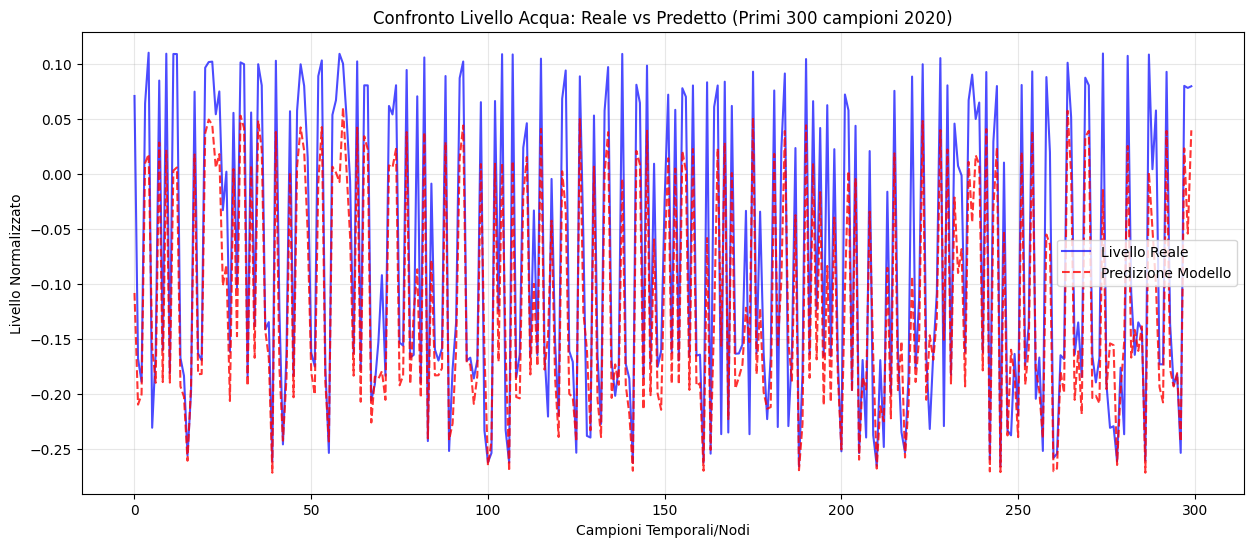

In [12]:
# --- CELLA PREVISIONI TEST SET 2020 ---

import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# 1. Caricamento del miglior modello salvato
print("Caricamento del modello per il test...")
model = CNN_LSTM_Predictor(seq_len=SEQ_LEN, hidden_size=128, dropout=0.3).to(device)
model = load_best_model(model, CHECKPOINT_DIR)
model.eval()

# 2. Preparazione del Dataset di Test (2020)
# Usiamo le versioni normalizzate dei dati 2020 caricate all'inizio
print("Preparazione Dataset 2020...")
test_dataset = MemoryEfficientDataset(
    eph=eph_test,
    u10=test_u10_norm,
    v10=test_v10_norm,
    msl=test_msl_norm,
    wl=wl_test,
    lat=lat_norm,
    lon=lon_norm,
    seq_len=SEQ_LEN,
    nodes_per_timestep=wl_test.shape[1] # Valutiamo su tutti i nodi per il test finale
)

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# 3. Loop di Predizione
test_preds = []
test_true = []

print(f"Esecuzione inferenza su {len(test_dataset)} campioni...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing 2020"):
        eph = batch['eph'].to(device)
        era5 = batch['era5'].to(device)
        coords = batch['coords'].to(device)
        targets = batch['target'].squeeze().to(device)

        # Forward pass
        outputs = model(eph, era5, coords)

        test_preds.append(outputs.cpu().numpy())
        test_true.append(targets.cpu().numpy())

# Appiattimento dei risultati
test_preds = np.concatenate(test_preds)
test_true = np.concatenate(test_true)

# 4. Calcolo Metriche Finali
final_rmse = np.sqrt(mean_squared_error(test_true, test_preds))
final_mae = np.mean(np.abs(test_true - test_preds))

print(f"\n{'='*60}")
print(f"📊 RISULTATI FINALI TEST SET 2020")
print(f"{'='*60}")
print(f"RMSE Finale: {final_rmse:.5f}")
print(f"MAE Finale:  {final_mae:.5f}")

print(f"{'='*60}")

# --- 5. Visualizzazione Grafica (Opzionale) ---
plt.figure(figsize=(15, 6))
plt.plot(test_true[:300], label='Livello Reale', color='blue', alpha=0.7)
plt.plot(test_preds[:300], label='Predizione Modello', color='red', linestyle='--', alpha=0.8)
plt.title('Confronto Livello Acqua: Reale vs Predetto (Primi 300 campioni 2020)')
plt.xlabel('Campioni Temporali/Nodi')
plt.ylabel('Livello Normalizzato')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()